# Prediction for tips

In [244]:
%config InlineBackend.figure_format='retina'

## General Idea

* Take subset with tipping (only Credit!)
* Calculate percentige
* Get duration
* Get average speed
* Get locations (tipping may be dependant on pickup/dropoff loc)
    * Maybe data will get to big -> take subset before

In [253]:
# Manage imports
import numpy as np
import pandas as pd
import seaborn as sns  
import matplotlib.pyplot as plt
df = pd.read_csv("clean.csv")

In [254]:
df = df.drop('Unnamed: 0', axis=1)

# Feat Eng

In [255]:
df = df[df.payment_type==1]

In [256]:
# drop unused variables
df = df.drop(['fare_amount',"payment_type",'tolls_amount','extra','mta_tax'],axis=1)

In [257]:
df['weekday'] = pd.to_datetime(df.tpep_pickup_datetime).dt.weekday_name

In [260]:
print(df.tip_amount.count(),"hallo")

5563869 hallo


In [261]:
# Calculate subtotal
df['subtotal'] = df.total_amount - df.tip_amount

# Calculating the tip percentage.
df['tip_perc'] = (df.tip_amount / df.subtotal) * 100

df['duration'] = pd.to_datetime(df["tpep_dropoff_datetime"])-pd.to_datetime(df["tpep_pickup_datetime"])

df['duration'] = df.duration.dt.total_seconds()


df['pickup_hour'] = pd.to_datetime(df.tpep_pickup_datetime).dt.hour

df['pickup_coord']=list(zip(df.pickup_latitude, df.pickup_longitude))
df['dropoff_coord']=list(zip(df.dropoff_latitude, df.dropoff_longitude))

# Calulcate avg speed (mph)
df['mph'] = (df.trip_distance)/(df.duration/3600)

c = df.mph.count()
df = df.drop(df[(df.trip_distance < 0.1) | (df.trip_distance > 100) ].index)
print("Dropped ",c-df.mph.count()," Elements (Unreasonable trip distance)")
c = df.mph.count()
df = df.drop(df[(df.mph < 0.5) | (df.mph > 80) ].index)
print("Dropped ",c-df.mph.count()," Elements (Unreasonable speed)")
c = df.mph.count()
df = df.drop(df[df.tip_perc > 50].index)
print("Dropped ",c-df.mph.count()," Elements (Huge tip)")


Dropped  6554  Elements (Unreasonable trip distance)
Dropped  994  Elements (Unreasonable speed)
Dropped  18390  Elements (Huge tip)


## Explore

In [262]:
import reverse_geocoder as rg

In [263]:
df[df.RatecodeID == 3].head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,dropoff_longitude,dropoff_latitude,tip_amount,total_amount,duration,weekday,subtotal,tip_perc,pickup_hour,pickup_coord,dropoff_coord,mph
84,2016-06-09 21:13:23,2016-06-09 21:43:05,1,16.36,-73.995018,40.750259,3,-74.185753,40.689320,22.76,98.64,1782.0,Thursday,75.88,29.994729,21,"(40.75025939941406, -73.9950180053711)","(40.689319610595696, -74.18575286865234)",33.050505
2539,2016-06-09 21:14:51,2016-06-09 21:49:26,1,14.72,-73.975258,40.754181,3,-74.163918,40.735260,14.36,86.16,2075.0,Thursday,71.80,20.000000,21,"(40.75418090820313, -73.97525787353516)","(40.735260009765625, -74.1639175415039)",25.538313
3469,2016-06-09 21:15:35,2016-06-09 21:52:38,1,14.00,-73.988045,40.732834,3,-74.177643,40.690327,14.25,85.55,2223.0,Thursday,71.30,19.985975,21,"(40.73283386230469, -73.98804473876955)","(40.69032669067383, -74.17764282226562)",22.672065
5418,2016-06-09 21:20:53,2016-06-09 21:59:04,5,14.00,-74.015244,40.708679,3,-74.177582,40.690472,10.00,82.30,2291.0,Thursday,72.30,13.831259,21,"(40.70867919921875, -74.01524353027342)","(40.69047164916992, -74.17758178710938)",21.999127
8243,2016-06-09 21:26:15,2016-06-09 21:57:04,2,10.86,-73.984238,40.763847,3,-74.040077,40.840382,7.00,73.30,1849.0,Thursday,66.30,10.558069,21,"(40.76384735107422, -73.98423767089844)","(40.84038162231445, -74.04007720947266)",21.144402


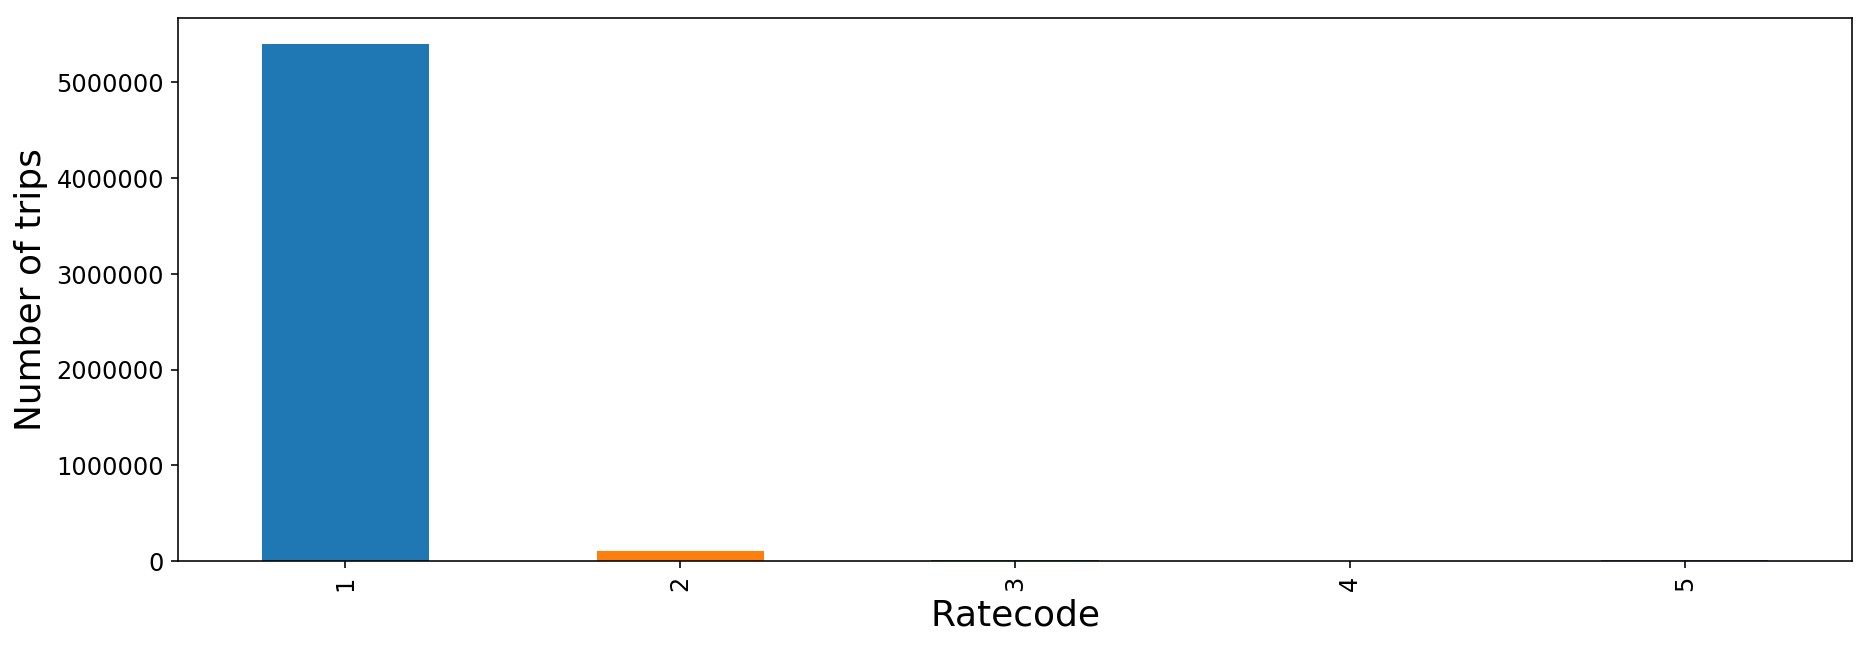

In [264]:
ax = df.groupby(['RatecodeID']).size().plot(kind='bar', figsize=(15, 5))

ax.set_xlabel('Ratecode', fontsize=18)
ax.set_ylabel('Number of trips', fontsize=18)
ax.tick_params(labelsize=12)

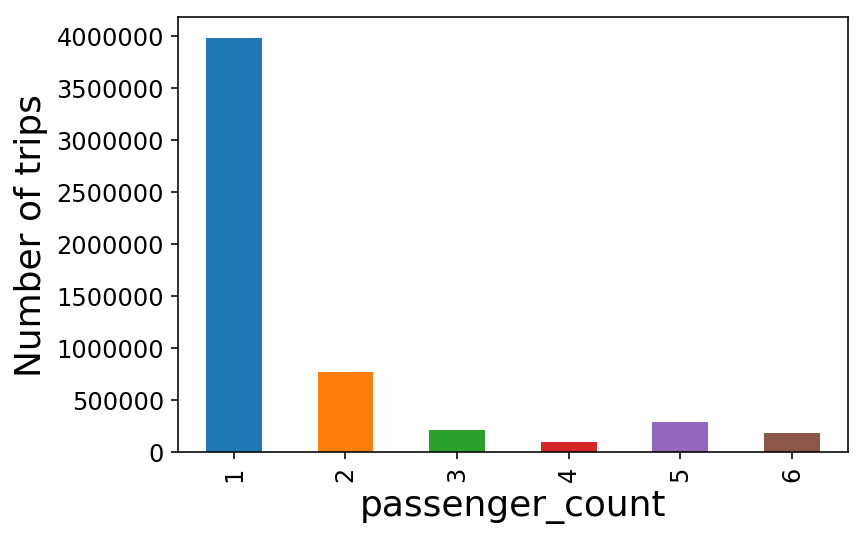

In [265]:
ax = df.groupby('passenger_count').size().plot(kind='bar')

ax.set_xlabel('passenger_count', fontsize=18)
ax.set_ylabel('Number of trips', fontsize=18)
ax.tick_params(labelsize=12)

In [283]:
data = df.sample(100000)

pickup_x = data.pickup_longitude.values
pickup_y = data.pickup_latitude.values
dropoff_x = data.dropoff_longitude.values
dropoff_y = data.dropoff_latitude.values

margin = 0.3
long_min = 40.756716 - margin
long_max = 40.756716 + margin
lat_min = -73.985368 - margin
lat_max = -73.985368 + margin

Text(0.5,1,'coordinates')

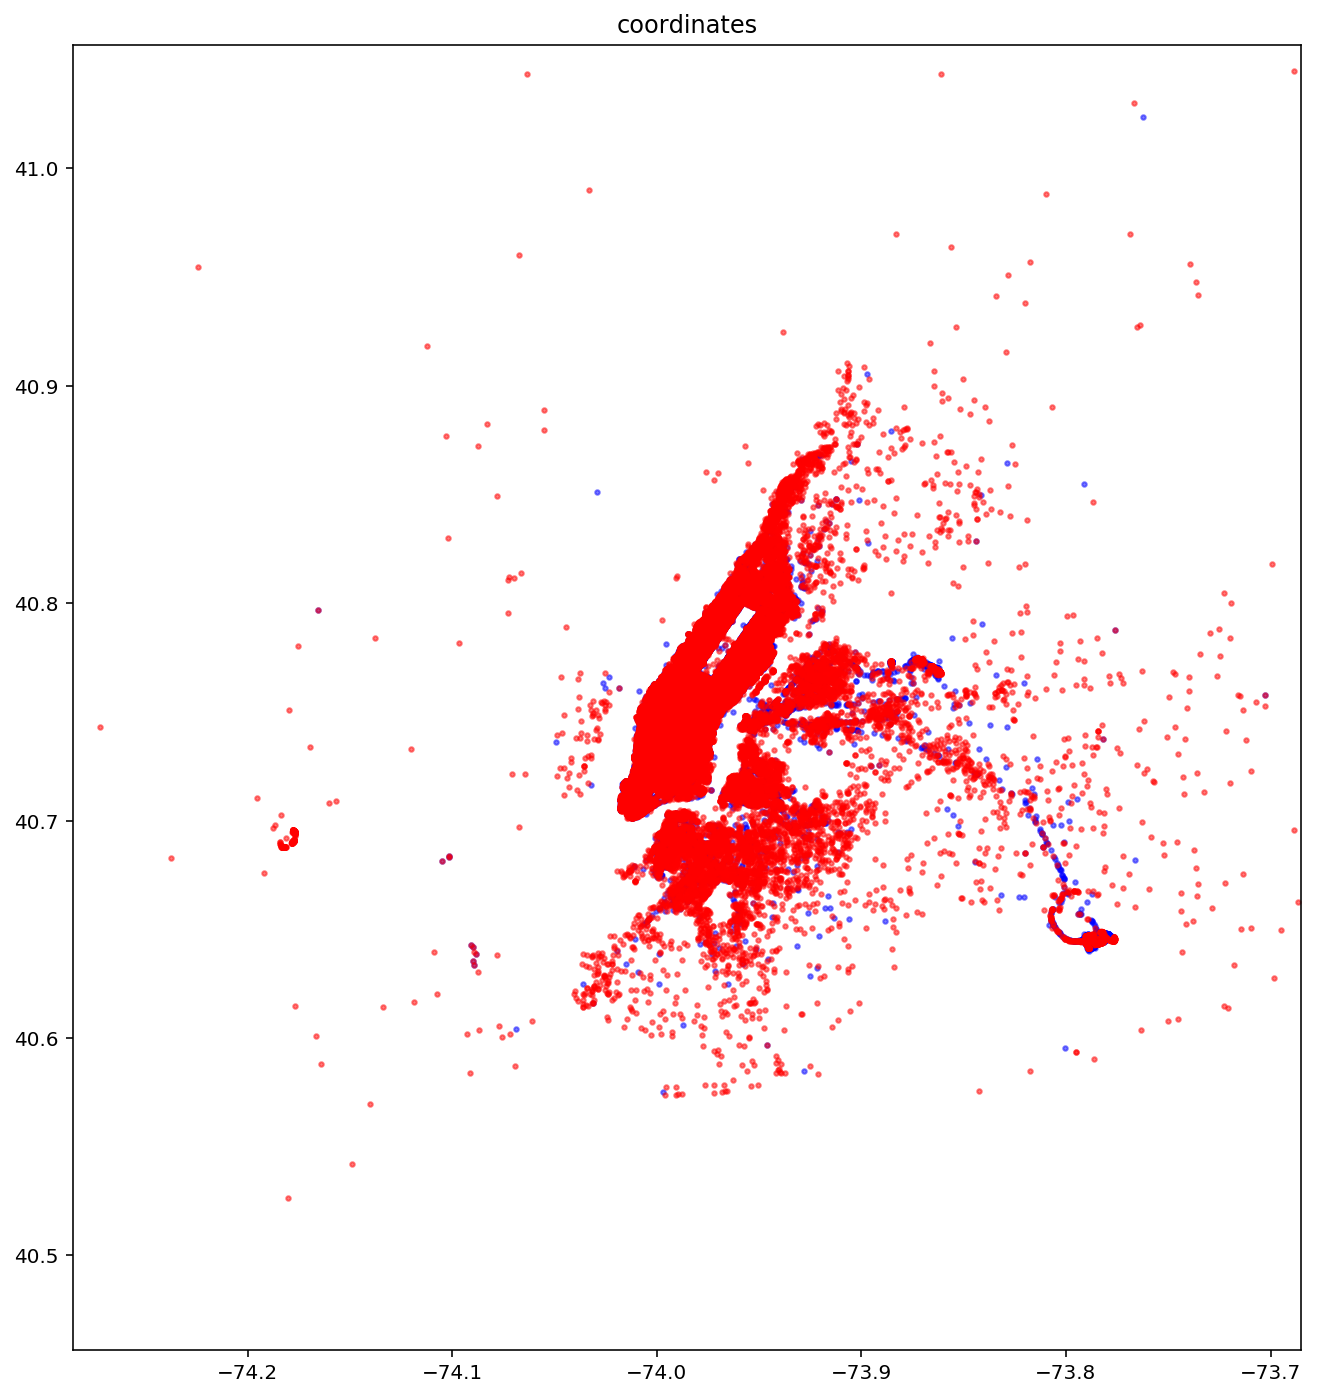

In [284]:
fig, ax = plt.subplots(figsize=(11, 12))

ax.scatter(pickup_x, pickup_y, s=5, color='blue', alpha=0.5)
ax.scatter(dropoff_x, dropoff_y, s=5, color='red', alpha=0.5)



ax.set_xlim([lat_min, lat_max])
ax.set_ylim([long_min, long_max])

ax.set_title('coordinates')

Text(0.5,1,'coordinates')

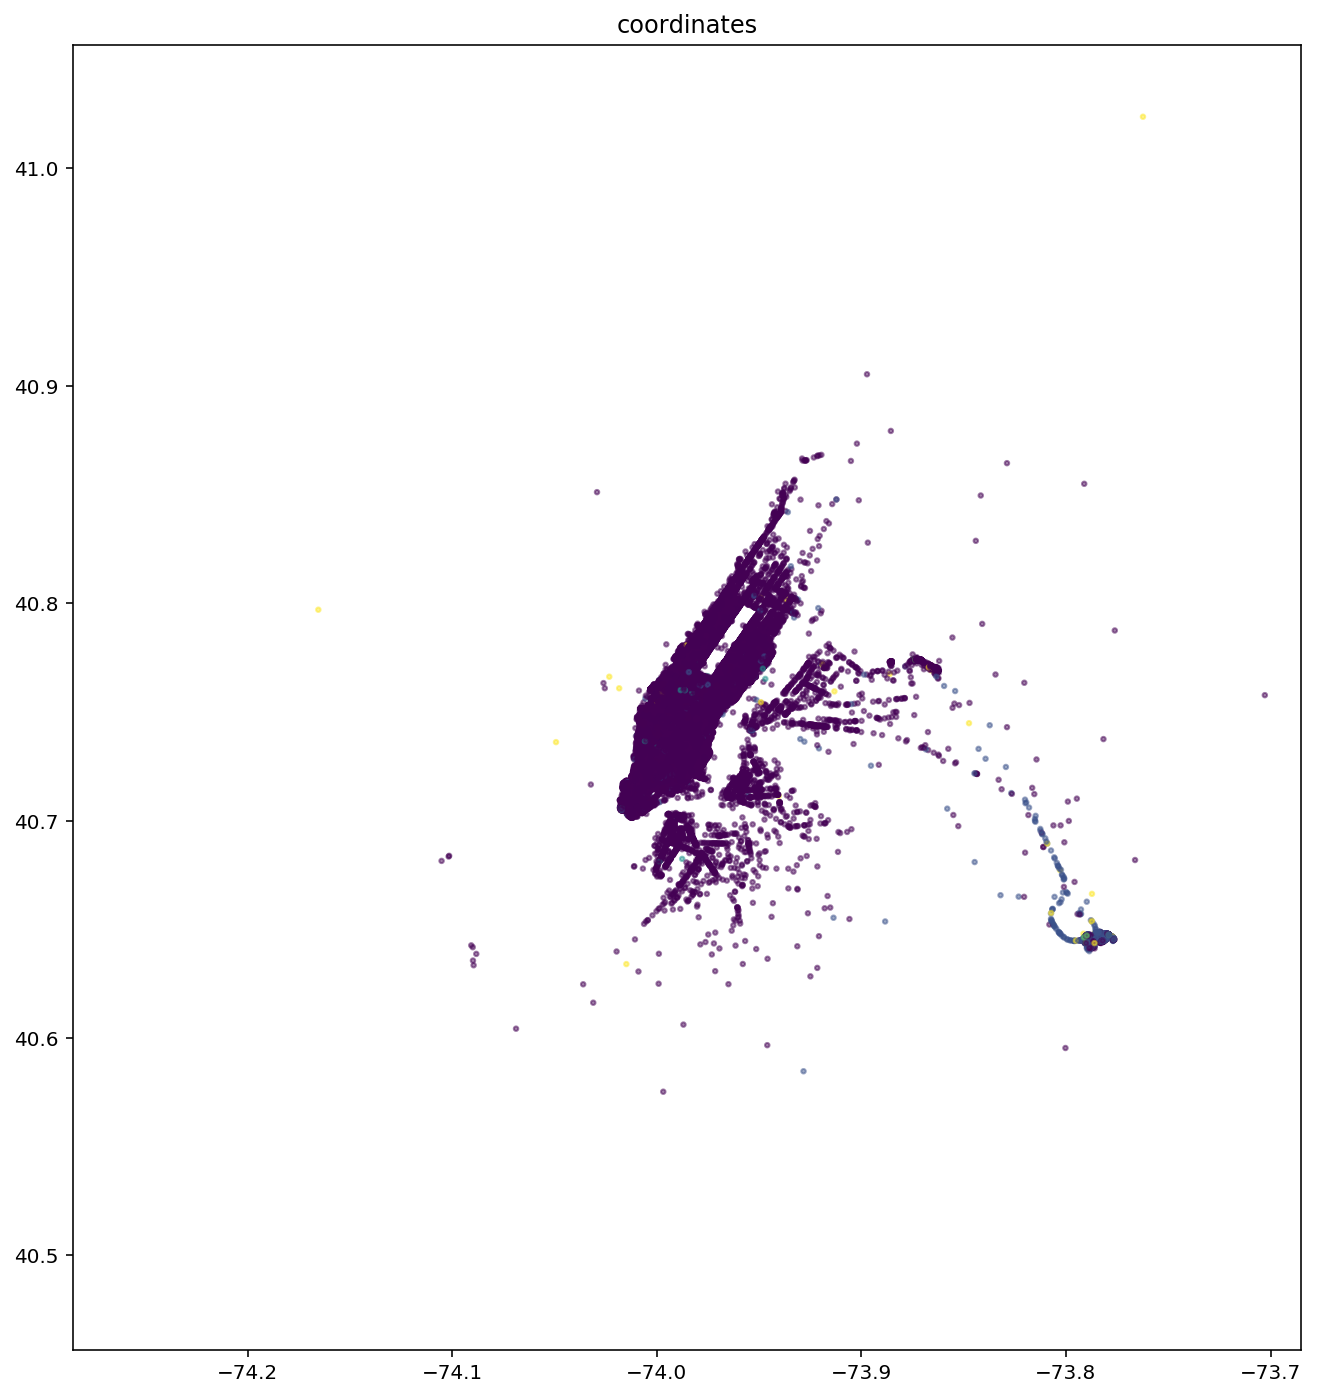

In [285]:
fig, ax = plt.subplots(figsize=(11, 12))

ax.scatter(pickup_x, pickup_y, s=5, c=data.RatecodeID, alpha=0.5)
ax.set_xlim([lat_min, lat_max])
ax.set_ylim([long_min, long_max])

ax.set_title('coordinates')

Text(0.5,1,'coordinates')

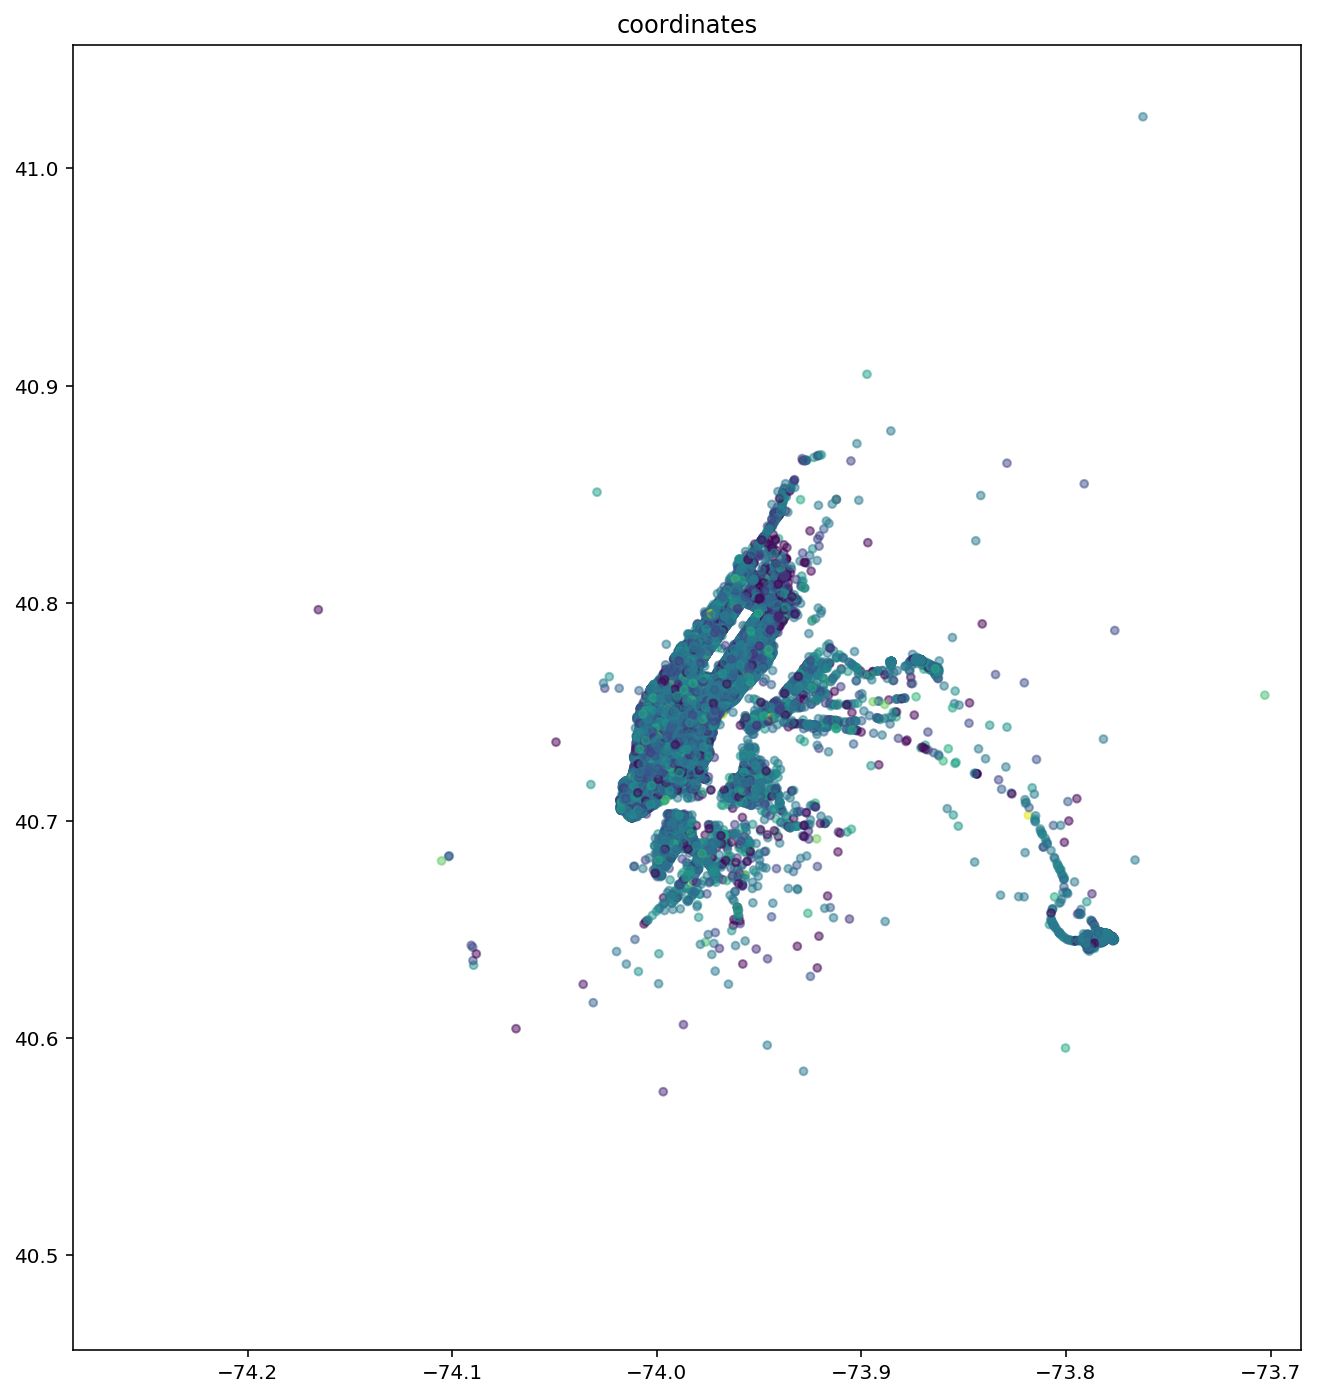

In [286]:
tip_values = data.tip_perc.values

fig, ax = plt.subplots(figsize=(11, 12))

ax.scatter(pickup_x, pickup_y, s=15, c=tip_values, alpha=0.5)


ax.set_xlim([lat_min, lat_max])
ax.set_ylim([long_min, long_max])

ax.set_title('coordinates')

Text(0.5,1,'coordinates')

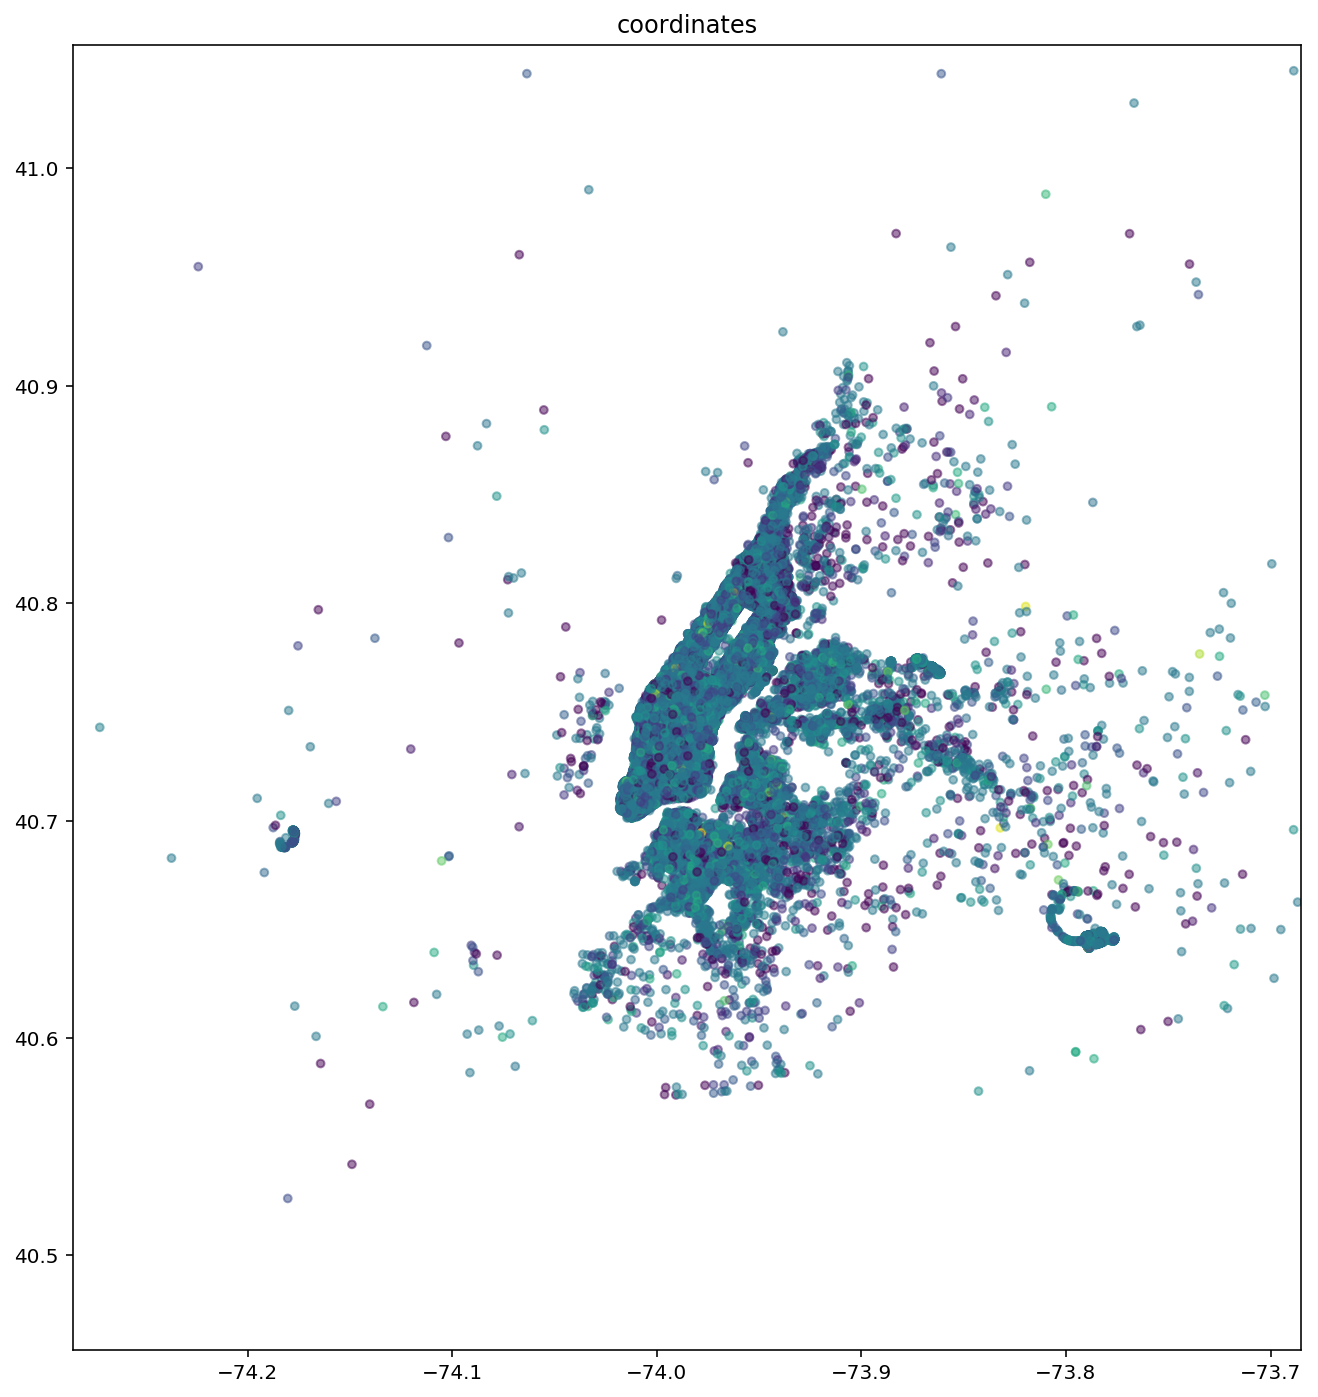

In [287]:
tip_values = data.tip_perc.values

fig, ax = plt.subplots(figsize=(11, 12))

ax.scatter(dropoff_x, dropoff_y, s=15, c=tip_values, alpha=0.5)


ax.set_xlim([lat_min, lat_max])
ax.set_ylim([long_min, long_max])

ax.set_title('coordinates')

In [18]:
# Coordinates variables.
min_x = -74.361107
min_y = 40.459518

max_x = -71.903083
max_y = 41.175342

step_x = 0.003205  # 270 meters (885 feet) approximately.
step_y = 0.002429  # 270 meters (885 feet) approximately.

# Number of maximum areas per axis in the 'area matrix'.
max_area_x = 766  # int((max_x - min_x) / step_x)
max_area_y = 294  # int((max_y - min_y) / step_y)

# Number of columns of the 'area matrix'.
num_columns = 767  # max_area_x + 1

# The area at the top right corner in the 'area matrix'.
max_area = 226264  # (max_area_y * num_columns) + max_area_x

# Minimum number of pickups or dropoffs per area.
min_area_number = 20


# Columns for creating the pickup and dropoff area attributes.
area_column_names = ['pickup_area', 'dropoff_area']
area_necesary_columns = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']


# Functions for calculating the pickup and dropoff areas in the 'area matrix'.

def get_1d_area(coor, min_coor, step_coor):
    return int((coor - min_coor) / step_coor)

def get_area(area_x, area_y, columns):
    return (area_y * columns) + area_x

def calculate_area(row):
    pickup_x = get_1d_area(row.pickup_longitude, min_x, step_x)
    pickup_y = get_1d_area(row.pickup_latitude, min_y, step_y)
    pickup_area = get_area(pickup_x, pickup_y, num_columns)
    
    dropoff_x = get_1d_area(row.dropoff_longitude, min_x, step_x)
    dropoff_y = get_1d_area(row.dropoff_latitude, min_y, step_y)
    dropoff_area = get_area(dropoff_x, dropoff_y, num_columns)
    
    return pd.Series({
        area_column_names[0]: pickup_area,
        area_column_names[1]: dropoff_area
    })

In [19]:
for column in area_column_names:
    data[column] = np.nan

data = iterate_and_apply(data, calculate_area, area_necesary_columns)

NameError: name 'iterate_and_apply' is not defined

In [ ]:
color_list = ['red', 'cyan']

pickup = data.groupby(['pickup_area']).size().index
dropoff = data.groupby(['dropoff_area']).size().index

areas = np.concatenate([pickup, dropoff])
areas = np.unique(areas)

In [ ]:
fig, ax = plt.subplots(figsize=(22, 24))
for area in areas.tolist():
   # if area % 2 == 0:
   #     color = color_list[0]
   # else:
   #     color = color_list[1]
    data_pickup = data[(data.pickup_area == area)]
    data_dropoff = data[(data.dropoff_area == area)]
    pickup_x = data_pickup.pickup_longitude.values
    pickup_y = data_pickup.pickup_latitude.values
    dropoff_x = data_dropoff.dropoff_longitude.values
    dropoff_y = data_dropoff.dropoff_latitude.values
    areaAvg = data[(data.pickup_area == data_pickup)].tip_perc.mean()
    ax.scatter(pickup_x, pickup_y, s=5, c=m.to_rgba(areaAvg), alpha=0.5)
    ax.scatter(dropoff_x, dropoff_y, s=5, c=m.to_rgba(areaAvg), alpha=0.5)

ax.set_xlim([-74.1, -73.7])
ax.set_ylim([40.6, 40.9])

ax.set_title('coordinates')

In [ ]:
for area in pickup.tolist():
     print(data[(data.pickup_area == area)].tip_perc.mean())


In [ ]:
data.head()

## Constants

In [ ]:
# Tip percentage variables.
tip_perc_necesary_columns = ['fare_amount', 'extra', 'mta_tax', 'tip_amount']
tip_perc_column_name = 'tip_perc'


# Coordinates variables.
min_x = -74.361107
min_y = 40.459518

max_x = -71.903083
max_y = 41.175342

step_x = 0.003205  # 270 meters (885 feet) approximately.
step_y = 0.002429  # 270 meters (885 feet) approximately.

# Number of maximum areas per axis in the 'area matrix'.
max_area_x = 766  # int((max_x - min_x) / step_x)
max_area_y = 294  # int((max_y - min_y) / step_y)

# Number of columns of the 'area matrix'.
num_columns = 767  # max_area_x + 1

# The area at the top right corner in the 'area matrix'.
max_area = 226264  # (max_area_y * num_columns) + max_area_x

# Minimum number of pickups or dropoffs per area.
min_area_number = 20

# Columns for creating the pickup and dropoff area attributes.
area_column_names = ['pickup_area', 'dropoff_area']
area_necesary_columns = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']


## Functions

In [ ]:
# FUNCTIONS

# Functions for calculating. the pickup and dropoff areas in the 'area matrix'.
def get_1d_area(coor, min_coor, step_coor):
    return int((coor - min_coor) / step_coor)

def get_area(area_x, area_y, columns):
    return (area_y * columns) + area_x

def calculate_area(row):
    pickup_x = get_1d_area(row.pickup_longitude, min_x, step_x)
    pickup_y = get_1d_area(row.pickup_latitude, min_y, step_y)
    pickup_area = get_area(pickup_x, pickup_y, num_columns)
    
    dropoff_x = get_1d_area(row.dropoff_longitude, min_x, step_x)
    dropoff_y = get_1d_area(row.dropoff_latitude, min_y, step_y)
    dropoff_area = get_area(dropoff_x, dropoff_y, num_columns)
    
    return pd.Series({
        area_column_names[0]: pickup_area,
        area_column_names[1]: dropoff_area
    })


# This auxiliary function applies another one to every row in a DataFrame for creating new columns.
def iterate_and_apply(dataframe, function, necesary_columns):
    perform = True
    step = 100000
    start = 0
    to = step
    
    while perform:
        new_columns = dataframe[start:to][necesary_columns].apply(function, axis=1)
        if len(new_columns) == 0:
            perform = False
        else:
            dataframe.update(new_columns)
        new_columns = None
        start += step
        to += step
    
    return dataframe

In [ ]:
#cords for a polygon around manhatten, manually set via google maps
manhattan_cords = [(40.882207, -73.933869), #1
         (40.872343, -73.908292), #2
         (40.836117, -73.933011), #3
         (40.804680, -73.931123), #4
         (40.798833, -73.918591), #5
         (40.739289, -73.967000), #6
         (40.707155, -73.973866), #7
         (40.699217, -74.021416), #8
         (40.759316, -74.012662)] #9

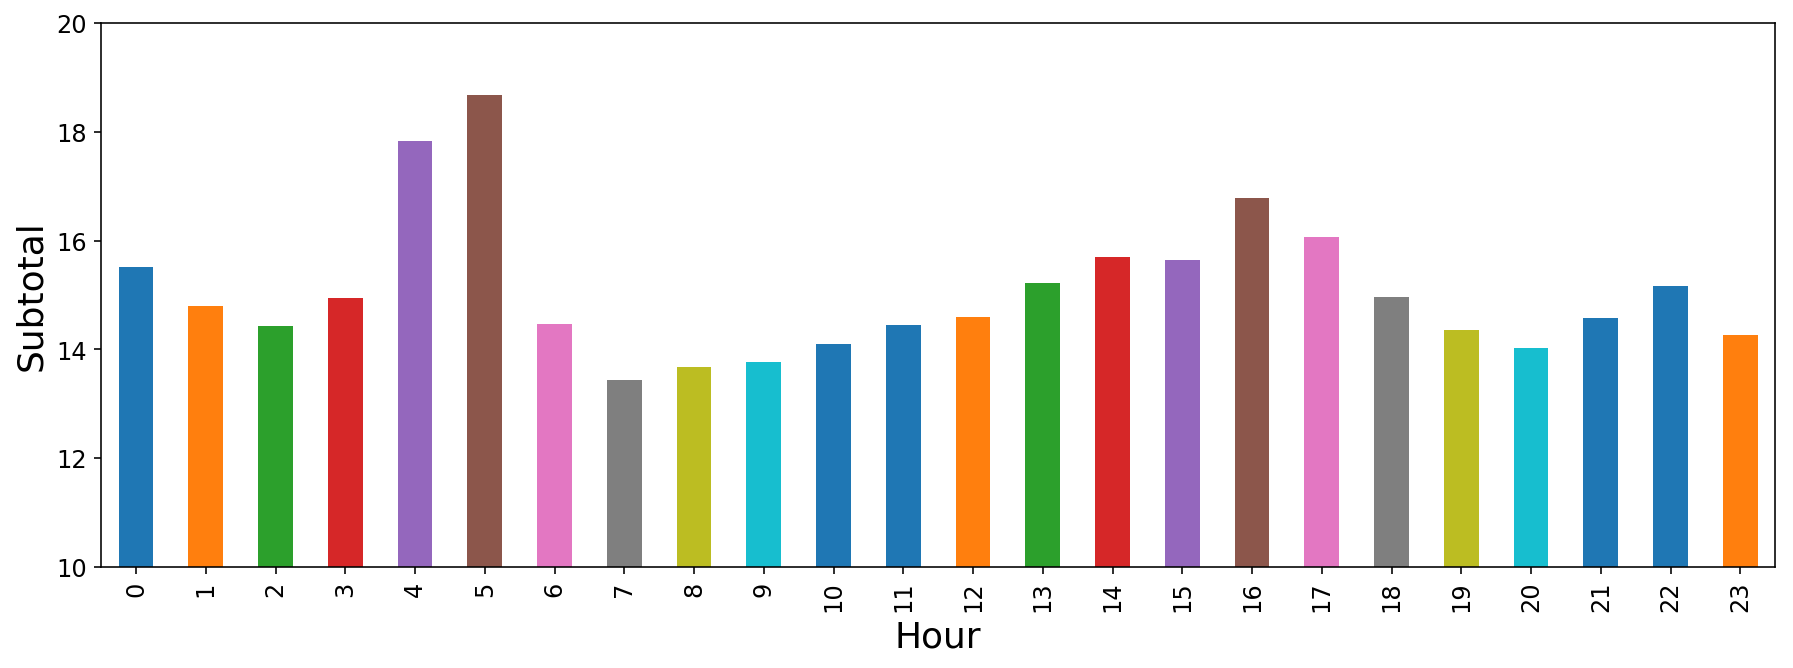

In [603]:
ax = df.groupby(['pickup_hour']).subtotal.mean().plot(kind='bar', figsize=(15, 5))
ax.set_ylim(10, 20)
ax.set_xlabel('Hour', fontsize=18)
ax.set_ylabel('Subtotal', fontsize=18)
ax.tick_params(labelsize=12)

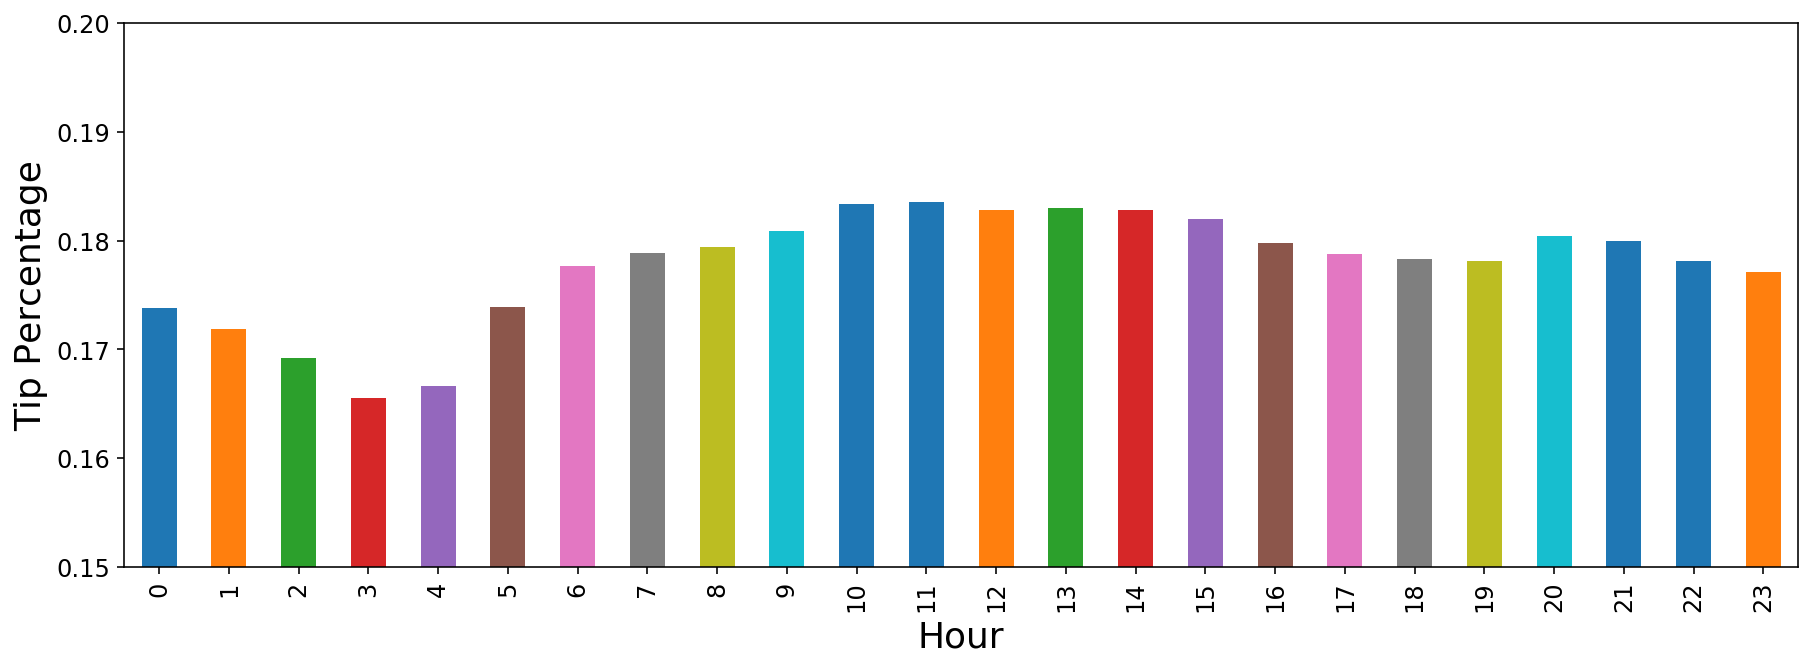

In [596]:
ax = df.groupby(['pickup_hour']).tip_perc.mean().plot(kind='bar', figsize=(15, 5))
ax.set_ylim(.15, .20)
ax.set_xlabel('Hour', fontsize=18)
ax.set_ylabel('Tip Percentage', fontsize=18)
ax.tick_params(labelsize=12)

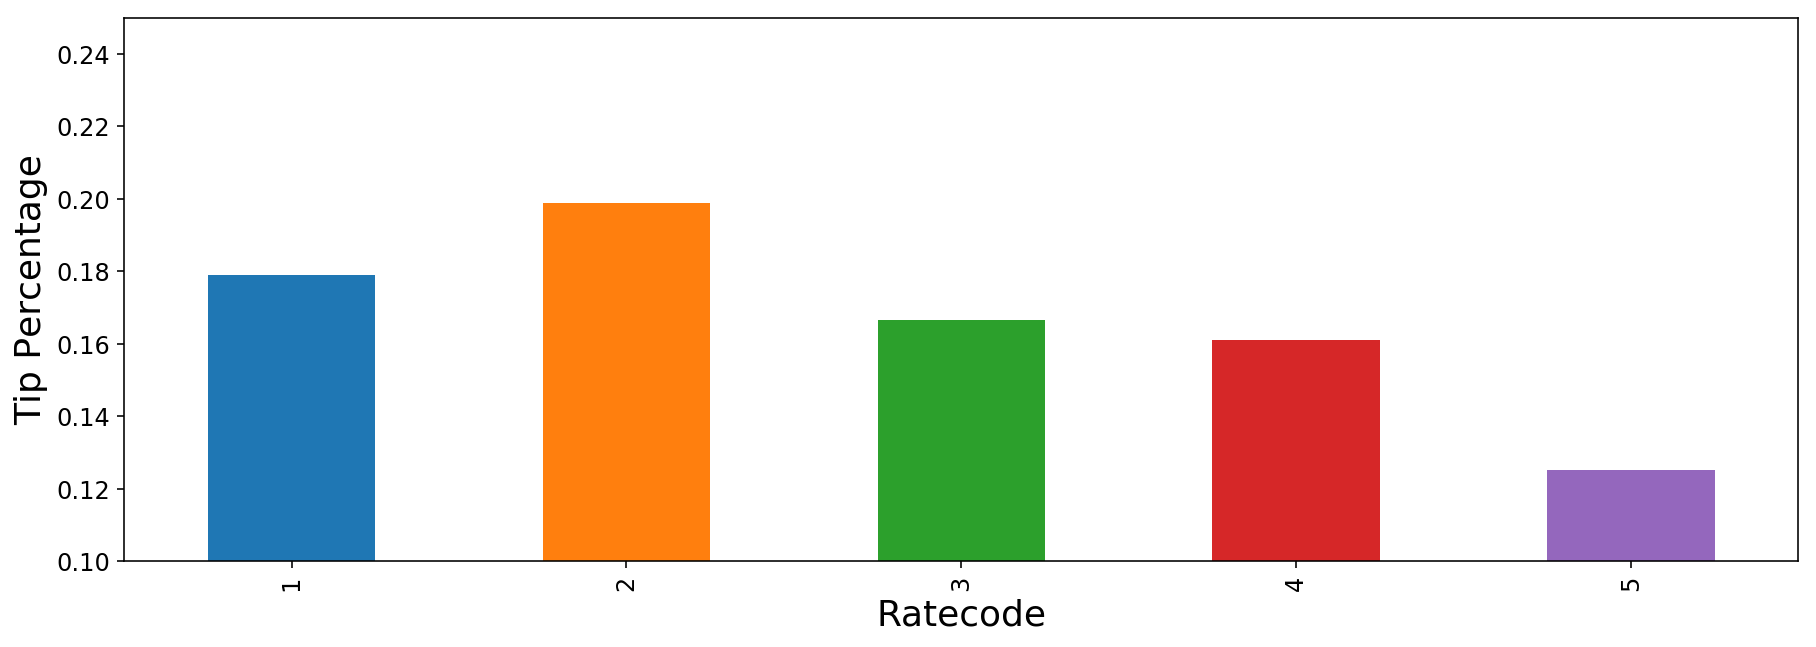

In [604]:
ax = df.groupby(['RatecodeID']).tip_perc.mean().plot(kind='bar', figsize=(15, 5))
ax.set_ylim(.10, .25)
ax.set_xlabel('Ratecode', fontsize=18)
ax.set_ylabel('Tip Percentage', fontsize=18)
ax.tick_params(labelsize=12)

In [598]:
df[df.RatecodeID == 5].tip_perc.mean()

0.1251050460572408

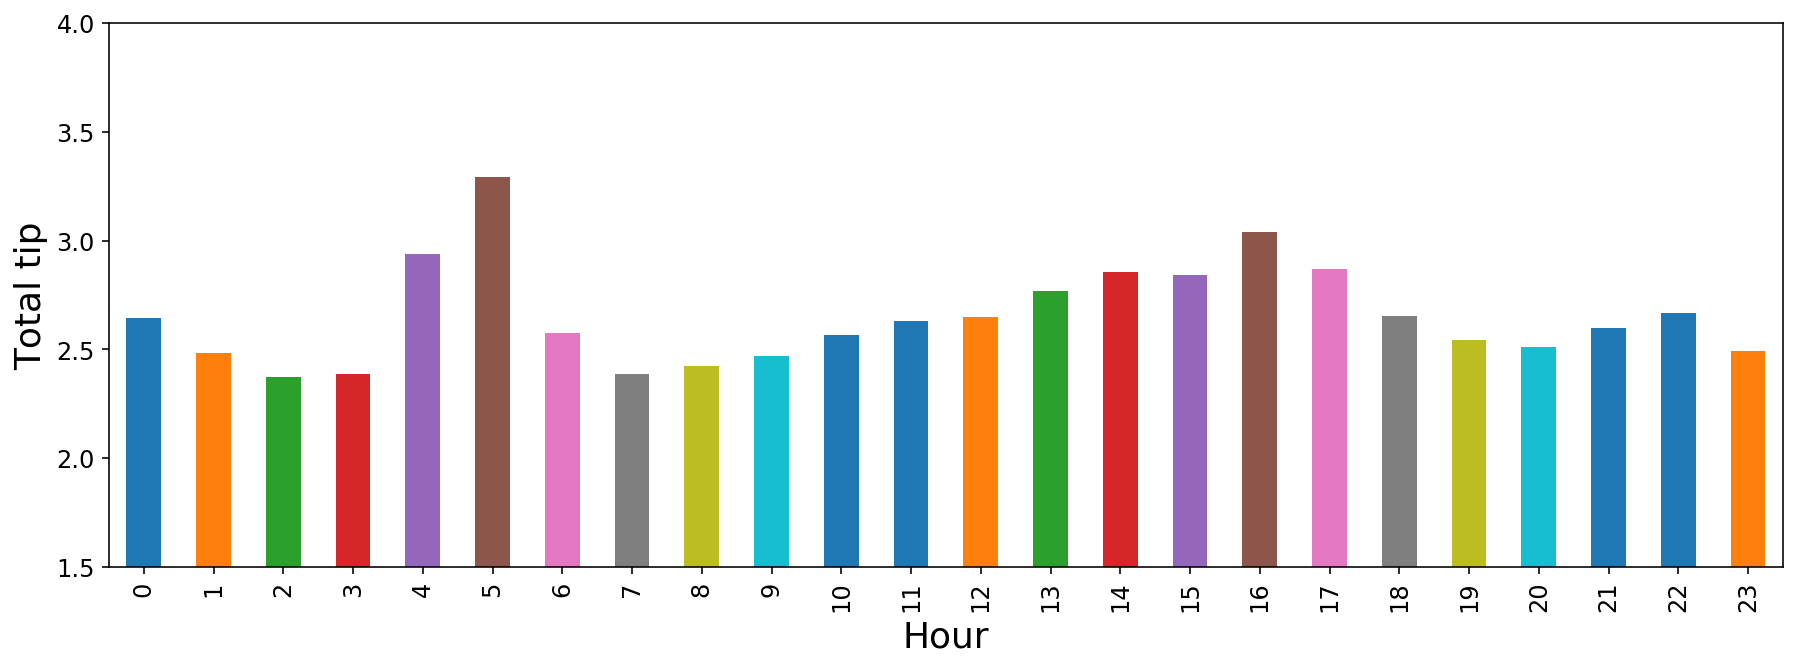

In [605]:
ax = df.groupby(['pickup_hour']).tip_amount.mean().plot(kind='bar', figsize=(15, 5))
ax.set_ylim(1.5, 4)
ax.set_xlabel('Hour', fontsize=18)
ax.set_ylabel('Total tip', fontsize=18)
ax.tick_params(labelsize=12)

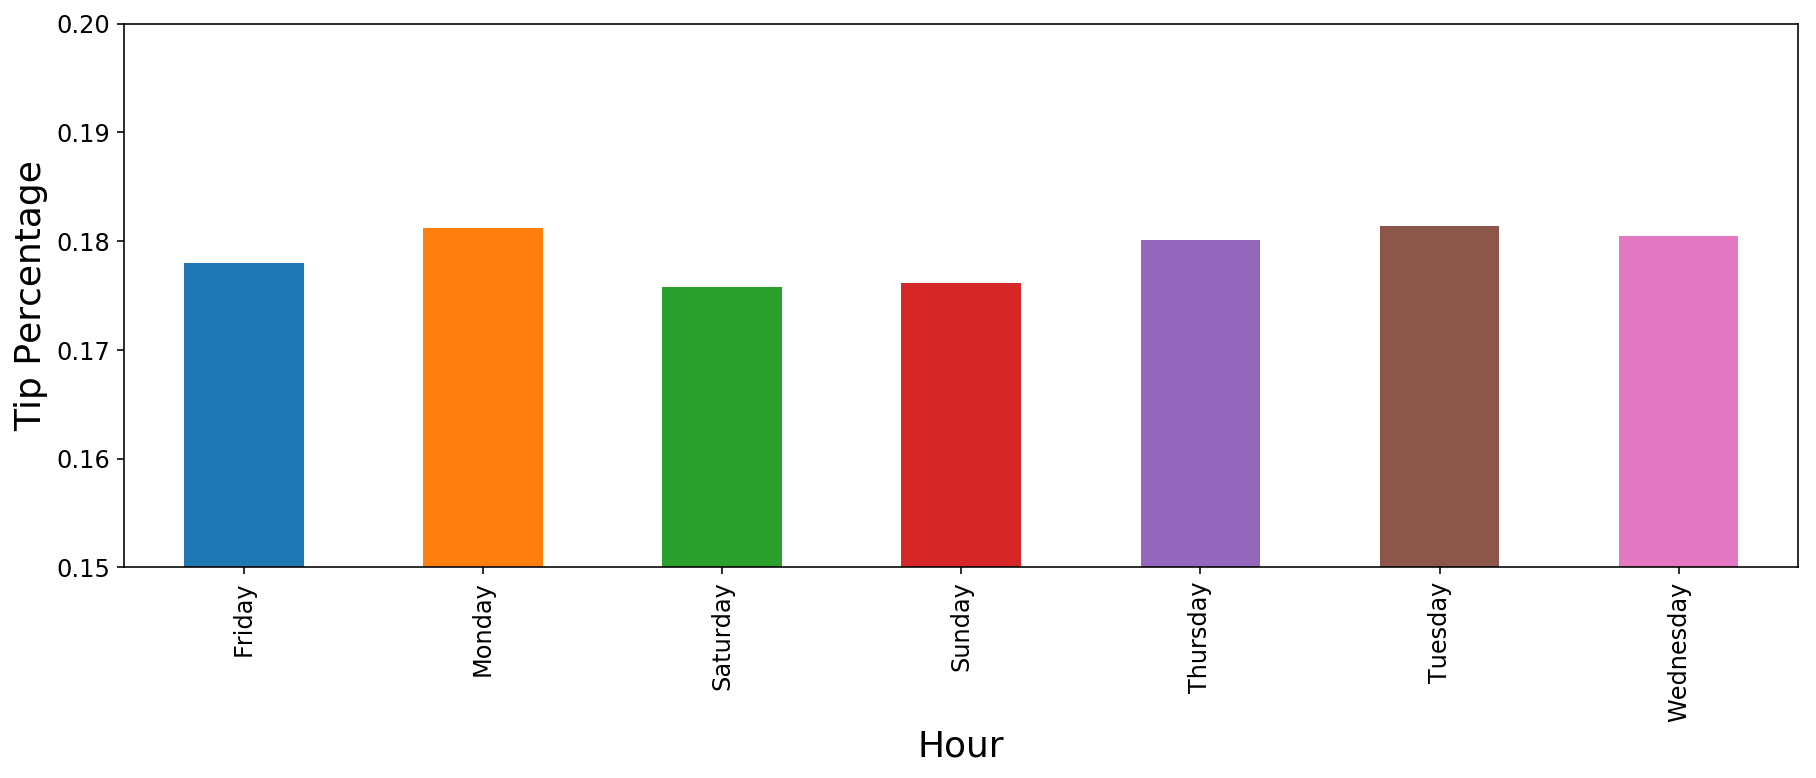

In [606]:
ax = df.groupby(['weekday']).tip_perc.mean().plot(kind='bar', figsize=(15, 5))
ax.set_ylim(.15, .20)
ax.set_xlabel('Hour', fontsize=18)
ax.set_ylabel('Tip Percentage', fontsize=18)
ax.tick_params(labelsize=12)

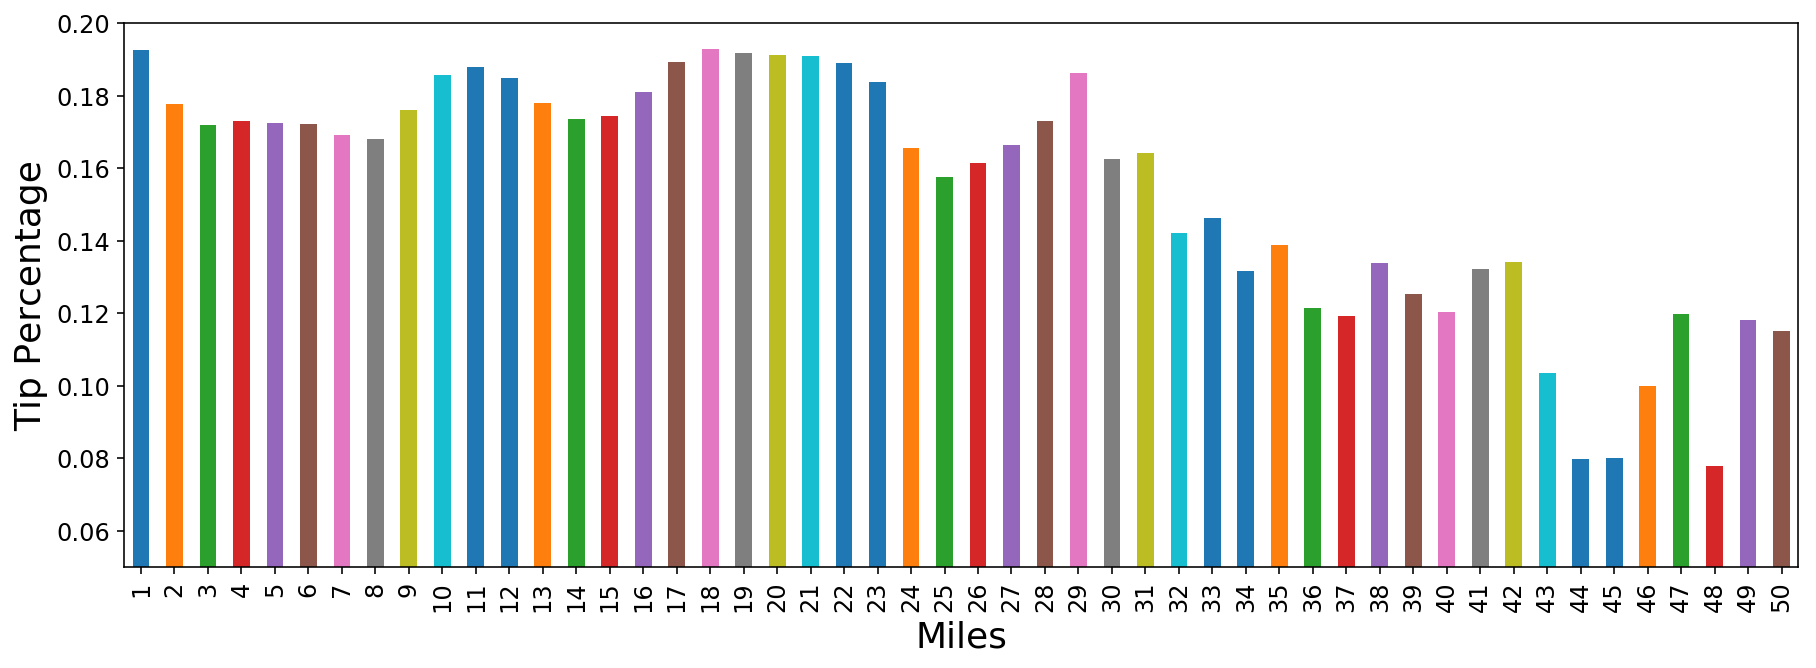

In [611]:
bins =  np.arange(0,50,1)
#bins = [0, 1, 5, 10, 25, 50, 100]

ind = np.digitize(df['trip_distance'],bins)

ax = df.groupby(ind).tip_perc.mean().plot(kind='bar', figsize=(15, 5))
ax.set_ylim(.05, .20)
ax.set_xlabel('Miles', fontsize=18)
ax.set_ylabel('Tip Percentage', fontsize=18)
ax.tick_params(labelsize=12)

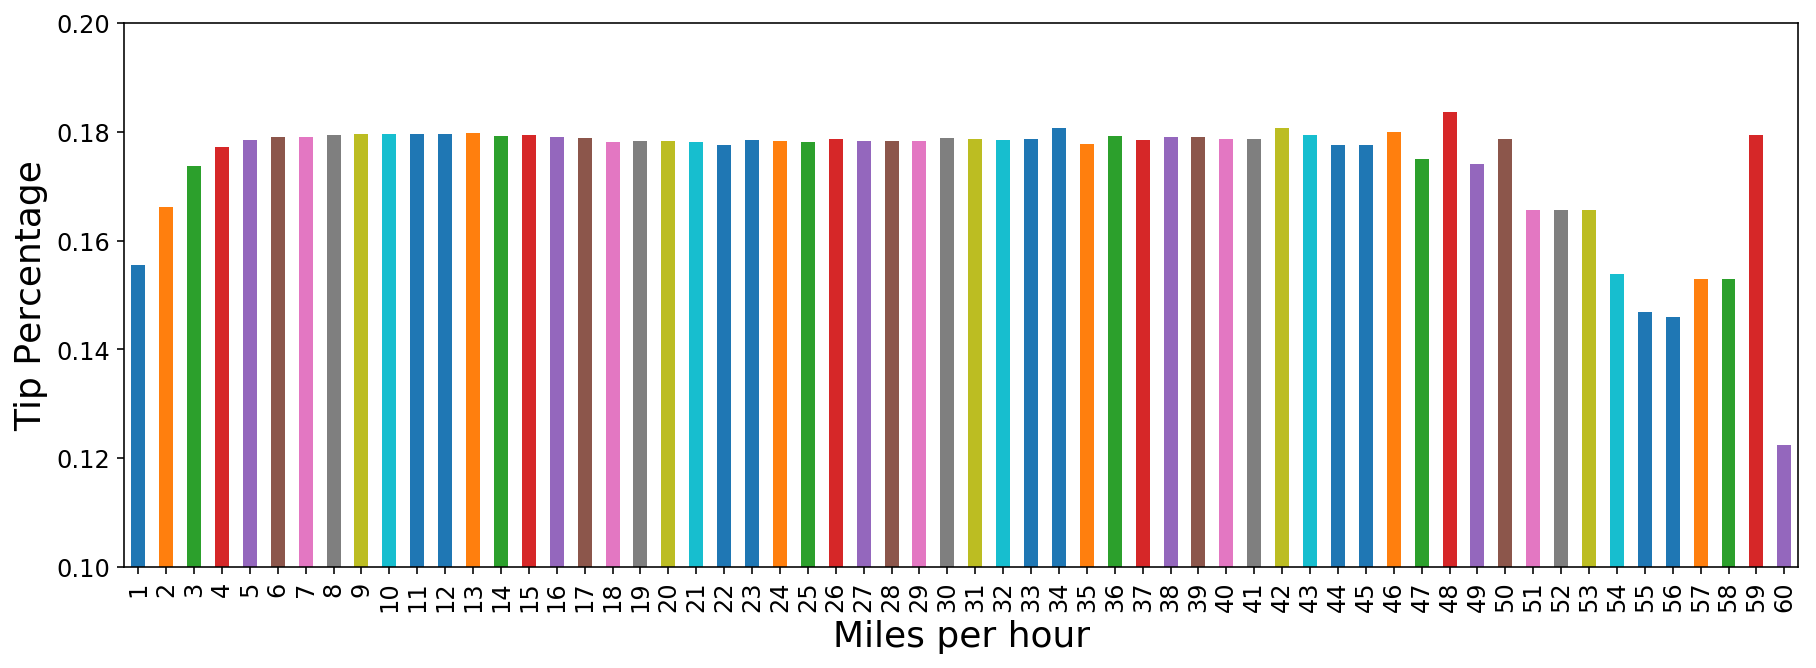

In [628]:
bins =  np.arange(0,60,1)
#bins = [0, 1, 5, 10, 25, 50, 100]

ind = np.digitize(df['mph'],bins)

ax = df.groupby(ind).tip_perc.mean().plot(kind='bar', figsize=(15, 5))
ax.set_ylim(.1, .20)
ax.set_xlabel('Miles per hour', fontsize=18)
ax.set_ylabel('Tip Percentage', fontsize=18)
ax.tick_params(labelsize=12)

In [748]:
df.groupby(['RatecodeID']).tip_perc.mean()

RatecodeID
1    0.178849
2    0.198726
3    0.166633
4    0.161043
5    0.125105
Name: tip_perc, dtype: float64

## Baseline

Calulcate the avg

Use as prediction baseline

In [641]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test \
    = train_test_split(df[['subtotal','tip_perc']]\
                     ,df['tip_amount'], test_size=0.2, random_state=1337)

In [746]:
avg = (df.tip_perc.mean())

In [747]:
avg

0.17912495926062952

In [643]:
baseline = (X_test.subtotal*avg).values

In [644]:
err = pd.DataFrame(y_test-baseline)
err.describe()

,tip_amount
count,1.107587e+06
mean,-2.065440e-02
std,1.293516e+00
min,-3.911014e+01
25%,-3.823620e-01
50%,1.837004e-01
75%,4.237633e-01
max,3.021269e+01


In [646]:
mean_absolute_error(baseline,y_test)

0.7556350548852732

In [483]:
avg = (df.groupby(['RatecodeID']).tip_perc.mean())/100

In [504]:
baseline = []

In [505]:
for index, row in X_test.iterrows():
    baseline.append(row['subtotal'] * avg[row['RatecodeID']])

In [506]:
baseline

[2.02099636504438,
 0.8584763320542498,
 2.3786948367336507,
 2.646968690500604,
 1.1267501858212028,
 2.3786948367336507,
 9.532664270519065,
 2.646968690500604,
 2.557544072578286,
 1.752722511277427,
 3.720064105568416,
 1.752722511277427,
 1.9315717471220624,
 2.557544072578286,
 1.0373255678988853,
 2.646968690500604,
 1.5738732754327915,
 1.573873275432791,
 3.2729410159568277,
 2.468119454655968,
 3.9883379593353694,
 4.256611813102322,
 1.6632978933551092,
 2.557544072578286,
 2.02099636504438,
 3.0940917801121923,
 1.5738732754327915,
 1.6632978933551092,
 8.556147442807356,
 2.825817926345239,
 4.34603643102464,
 0.6796270962096145,
 2.110420982966698,
 1.5738732754327915,
 4.703734902713911,
 1.3055994216658382,
 1.752722511277427,
 1.1267501858212028,
 0.7690517141319321,
 1.4844486575104738,
 2.110420982966698,
 1.1267501858212028,
 2.289270218811333,
 4.8825841385585464,
 3.6306394876460986,
 1.752722511277427,
 2.110420982966698,
 1.2161748037435205,
 2.02099636504438,
 

In [507]:
mean_squared_error(y_test,baseline)

1.2499755935213284

## test different Regressors and compare

In [647]:
df.pickup_hour = df.pickup_hour.astype('category')
df.RatecodeID = df.RatecodeID.astype('category')
df.passenger_count = df.passenger_count.astype('category')
sample = df.sample(1000000)

In [648]:
df_train = sample[['RatecodeID','pickup_hour','trip_distance',\
                   'subtotal','mph','pickup_latitude','dropoff_latitude','pickup_longitude','dropoff_longitude']]
df_train = pd.get_dummies(df_train, columns = ['pickup_hour','RatecodeID'] )

In [649]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 8196623 to 9006476
Data columns (total 36 columns):
trip_distance        1000000 non-null float64
subtotal             1000000 non-null float64
mph                  1000000 non-null float64
pickup_latitude      1000000 non-null float64
dropoff_latitude     1000000 non-null float64
pickup_longitude     1000000 non-null float64
dropoff_longitude    1000000 non-null float64
pickup_hour_0        1000000 non-null uint8
pickup_hour_1        1000000 non-null uint8
pickup_hour_2        1000000 non-null uint8
pickup_hour_3        1000000 non-null uint8
pickup_hour_4        1000000 non-null uint8
pickup_hour_5        1000000 non-null uint8
pickup_hour_6        1000000 non-null uint8
pickup_hour_7        1000000 non-null uint8
pickup_hour_8        1000000 non-null uint8
pickup_hour_9        1000000 non-null uint8
pickup_hour_10       1000000 non-null uint8
pickup_hour_11       1000000 non-null uint8
pickup_hour_12       1000000 no

In [658]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_train,sample['tip_amount'], test_size=0.2, random_state=1337)

In [634]:
from sklearn.metrics import mean_absolute_error, r2_score

In [559]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=8,random_state=1337)

rfr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=8, n_jobs=1,
           oob_score=False, random_state=1337, verbose=0, warm_start=False)

In [560]:
rfr_pred = rfr.predict(X_test)

In [561]:
err = pd.DataFrame(y_test-rfr_pred)
err.describe()

,tip_perc
count,20000.000000
mean,0.001212
std,0.072421
min,-0.356977
25%,-0.036189
50%,0.007931
75%,0.043956
max,0.331043


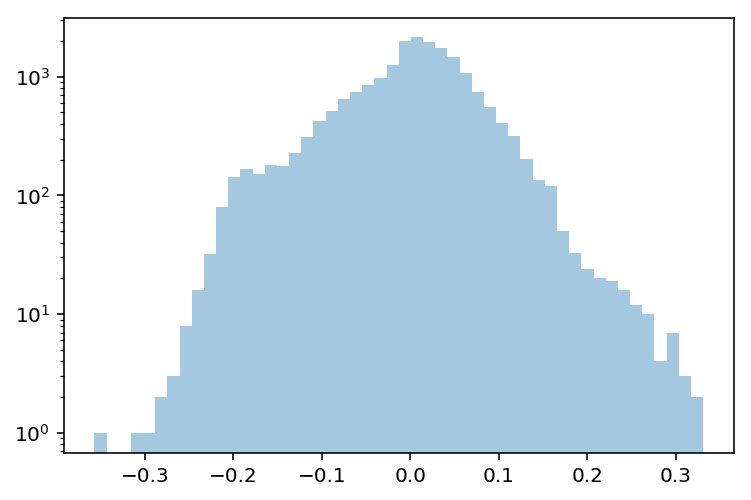

In [562]:
ax = sns.distplot(err,hist_kws={"log":True},kde=False);

In [563]:
# Feature importance# Feature 
pd.DataFrame({"Features" : X_train.columns,"estimatedCoefficients": rfr.feature_importances_})

,Features,estimatedCoefficients
0,RatecodeID,0.001363
1,trip_distance,0.095303
2,subtotal,0.074614
3,mph,0.131922
4,pickup_latitude,0.133430
5,dropoff_latitude,0.135429
6,pickup_longitude,0.139485
7,dropoff_longitude,0.139043
8,pickup_hour_0,0.006929
9,pickup_hour_1,0.005286


In [573]:
mean_squared_error(y_test,rfr_pred)

0.07242957340074557

## Light GBM

In [659]:
import lightgbm as lgb

d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = .05
params['boosting_type'] = 'gbdt'
params['min_samples_split'] = 3
params['min_samples_leaf'] = 15
params['max_features'] = 'sqrt'
params['max_depth'] = 10
params['subsample'] = 0.8
clf = lgb.train(params, d_train, 300)

In [660]:
y_pred = clf.predict(X_test)

In [661]:
mean_absolute_error(y_test,y_pred)

0.7303391132365965

In [662]:
err = pd.DataFrame(y_test-y_pred)
err.describe()

,tip_amount
count,200000.000000
mean,-0.001159
std,1.230805
min,-25.169853
25%,-0.360864
50%,0.147757
75%,0.449106
max,30.694892


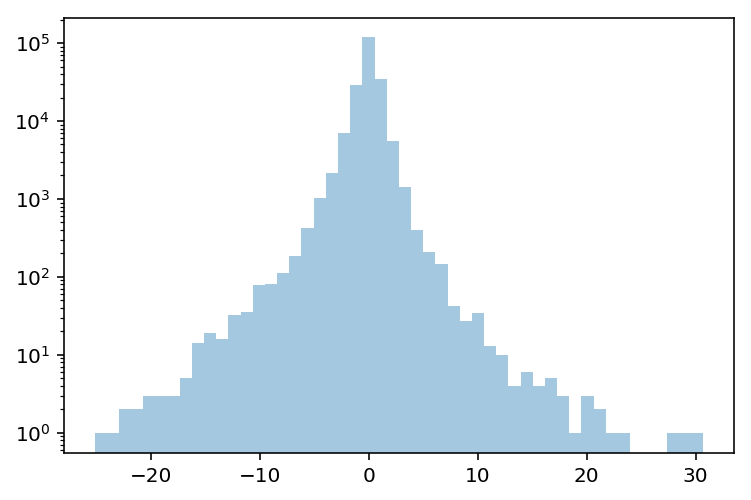

In [663]:
ax = sns.distplot(err,hist_kws={"log":True},kde=False);

In [664]:
clf.feature_importance(importance_type='split')

array([ 692, 2819,  783,  985, 1105,  980,  872,   40,   55,   60,   74,
         57,   29,   18,   23,    3,    1,   11,   10,   11,    6,   18,
         15,   13,    5,    4,    8,   17,   14,   14,    7,   48,   34,
         17,   19,  133])

In [665]:
clf.feature_name()

['trip_distance',
 'subtotal',
 'mph',
 'pickup_latitude',
 'dropoff_latitude',
 'pickup_longitude',
 'dropoff_longitude',
 'pickup_hour_0',
 'pickup_hour_1',
 'pickup_hour_2',
 'pickup_hour_3',
 'pickup_hour_4',
 'pickup_hour_5',
 'pickup_hour_6',
 'pickup_hour_7',
 'pickup_hour_8',
 'pickup_hour_9',
 'pickup_hour_10',
 'pickup_hour_11',
 'pickup_hour_12',
 'pickup_hour_13',
 'pickup_hour_14',
 'pickup_hour_15',
 'pickup_hour_16',
 'pickup_hour_17',
 'pickup_hour_18',
 'pickup_hour_19',
 'pickup_hour_20',
 'pickup_hour_21',
 'pickup_hour_22',
 'pickup_hour_23',
 'RatecodeID_1',
 'RatecodeID_2',
 'RatecodeID_3',
 'RatecodeID_4',
 'RatecodeID_5']

In [671]:
test_prediction = pd.read_csv("test_prediction.csv",index_col=0)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (9,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [674]:
test_prediction.describe()

,RatecodeID,VendorID,avg_speed,bridge,dropoff_latitude,dropoff_longitude,duration_seconds,fare_amount_prediction,id,improvement_surcharge,inCityPercentage,in_city_distance,out_of_city_distance,passenger_count,payment_type,pickup_latitude,pickup_longitude,tolls_amount,total_over_bridge_distance,trip_distance
count,64000.000000,64000.000000,64000.000000,238.00000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,238.000000,238.000000,238.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.00000,238.000000,64000.000000
mean,1.406250,1.537047,14.546904,9.89916,40.746855,-73.975568,1230.515344,23.213414,32000.500000,0.299991,0.163742,3.746822,12.461605,1.671188,1.337031,40.744481,-73.960769,1.74787,16.208426,5.896713
std,0.913769,0.498630,9.388043,4.81803,0.047903,0.084823,1080.955692,23.945688,18475.352951,0.001677,0.137258,2.437175,6.509709,1.303686,0.492926,0.037676,0.060701,4.14628,6.321360,7.234262
min,1.000000,1.000000,0.014337,0.00000,40.045311,-74.833679,40.000000,3.500000,1.000000,0.000000,0.010303,0.549551,0.662656,0.000000,1.000000,40.535580,-74.527763,0.00000,1.763670,0.010000
25%,1.000000,1.000000,8.153310,7.00000,40.725780,-73.993828,468.000000,7.500000,16000.750000,0.300000,0.057944,1.568585,8.278194,1.000000,1.000000,40.732536,-73.991264,0.00000,12.896369,1.200000
50%,1.000000,2.000000,11.716077,10.00000,40.751484,-73.980309,858.000000,12.000000,32000.500000,0.300000,0.128908,3.546776,11.964156,1.000000,1.000000,40.752197,-73.980370,0.00000,15.435084,2.260000
75%,1.000000,2.000000,18.140034,12.00000,40.768697,-73.960541,1659.000000,31.500000,48000.250000,0.300000,0.217778,5.115432,15.545136,2.000000,2.000000,40.766815,-73.962111,0.00000,18.683674,8.080000
max,5.000000,2.000000,176.170213,19.00000,41.525589,-72.551582,9931.000000,195.500000,64000.000000,0.300000,0.706675,11.433199,37.757120,9.000000,4.000000,41.255787,-72.659561,82.50000,39.327866,86.600000


## Calculate Extra

In [676]:
test_prediction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64000 entries, 0 to 63999
Data columns (total 26 columns):
RatecodeID                    64000 non-null int64
VendorID                      64000 non-null int64
avg_speed                     64000 non-null float64
bridge                        238 non-null float64
dropoff_latitude              64000 non-null float64
dropoff_longitude             64000 non-null float64
duration                      64000 non-null object
duration_seconds              64000 non-null float64
endsInManhattan               1000 non-null object
fare_amount_prediction        64000 non-null float64
id                            64000 non-null int64
improvement_surcharge         64000 non-null float64
inCityPercentage              238 non-null float64
in_city_distance              238 non-null float64
out_of_city_distance          238 non-null float64
passenger_count               64000 non-null int64
payment_type                  64000 non-null int64
pickup_lati

In [693]:
df.tolls_amount.mean()

AttributeError: 'DataFrame' object has no attribute 'tolls_amount'

In [681]:
# Get Holidays
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
dr = pd.date_range(start=test_prediction['tpep_pickup_datetime'].min(), end=test_prediction['tpep_pickup_datetime'].max())
holidays = cal.holidays(start=dr.min(), end=dr.max())
test_prediction['holiday'] = test_prediction['tpep_pickup_datetime'].isin(holidays)

In [682]:
test_prediction.holiday.value_counts()

False    64000
Name: holiday, dtype: int64

In [685]:
test_prediction["tpep_pickup_datetime"] = pd.to_datetime(test_prediction.tpep_pickup_datetime)
test_prediction['tpep_dropoff_datetime'] = pd.to_datetime(test_prediction.tpep_dropoff_datetime)

In [683]:
test_prediction['day'] = (pd.to_datetime(test_prediction['tpep_pickup_datetime']).dt.weekday_name)

In [688]:
test_prediction['rush_hour'] = \
    ((pd.to_datetime(test_prediction.tpep_pickup_datetime).dt.hour < 20) & \
      (pd.to_datetime(test_prediction.tpep_pickup_datetime).dt.hour >= 16)) \
    & \
    (test_prediction['day'].isin(["Monday","Tuesday","Wednesday","Thursday","Friday"])) &\
    (test_prediction['holiday'] == False)

In [689]:
#(pd.to_datetime(df.tpep_dropoff_datetime).dt.hour <= 5) | \
#(pd.to_datetime(df.tpep_dropoff_datetime).dt.hour >= 20) |  \

test_prediction['overnight'] = \
    (pd.to_datetime(test_prediction.tpep_pickup_datetime).dt.hour <= 5) | \
    (pd.to_datetime(test_prediction.tpep_pickup_datetime).dt.hour >= 20)

In [690]:
conditions = [ \
    (test_prediction['overnight'] == True) & (test_prediction['rush_hour'] == False).isin([1,3,4]), \
    (test_prediction['overnight'] == True) & (test_prediction['rush_hour'] == True).isin([1,3,4]), \
    (test_prediction['overnight'] == False) & (test_prediction['rush_hour'] == True) & (test_prediction['RatecodeID'] == 2), \
    (test_prediction['overnight'] == False) & (test_prediction['rush_hour'] == True) & (test_prediction['RatecodeID'].isin([1,3,4])), \
]
choices = [.5, 1.5, 4.5, 1]
test_prediction['calcExtra'] = np.select(conditions, choices, default=0)

In [692]:
test_prediction.head()

,RatecodeID,VendorID,avg_speed,bridge,dropoff_latitude,dropoff_longitude,duration,duration_seconds,endsInManhattan,fare_amount_prediction,...,tolls_amount,total_over_bridge_distance,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance,holiday,day,rush_hour,overnight,calcExtra
0,1,1,7.128713,NaN,40.763371,-73.982536,0 days 00:03:22.000000000,202.0,NaN,4.0,...,0.0,NaN,2016-05-13 06:02:02,2016-05-13 05:58:40,0.40,False,Friday,False,True,0.5
1,1,2,23.700000,NaN,40.793541,-73.951691,0 days 00:04:00.000000000,240.0,NaN,6.5,...,0.0,NaN,2016-05-29 12:27:03,2016-05-29 12:23:03,1.58,False,Sunday,False,False,0.0
2,1,1,9.523810,NaN,40.738129,-74.008667,0 days 00:12:36.000000000,756.0,NaN,10.5,...,0.0,NaN,2016-05-28 23:25:35,2016-05-28 23:12:59,2.00,False,Saturday,False,True,0.5
3,1,2,8.958525,NaN,40.773708,-73.963829,0 days 00:07:14.000000000,434.0,NaN,6.5,...,0.0,NaN,2016-05-23 11:25:45,2016-05-23 11:18:31,1.08,False,Monday,False,False,0.0
4,1,2,5.063939,NaN,40.761654,-73.983566,0 days 00:26:04.000000000,1564.0,NaN,16.5,...,0.0,NaN,2016-05-06 09:06:02,2016-05-06 08:39:58,2.20,False,Friday,False,False,0.0


In [694]:
conditions = [ \
    (test_prediction['RatecodeID'] == 3), \
    (test_prediction['RatecodeID'] == 5) \
]
choices = [0,  0.127649]
test_prediction['mta_tax'] = np.select(conditions, choices, default=0.5)

In [698]:
test_prediction['subtotal'] = test_prediction.mta_tax + test_prediction.tolls_amount + test_prediction.calcExtra\
    + test_prediction.fare_amount_prediction + 0.3

In [699]:
test_prediction['subtotal'].describe()

count    64000.000000
mean        26.104546
std         27.068910
min          4.300000
25%          8.300000
50%         12.800000
75%         35.300000
max        214.340000
Name: subtotal, dtype: float64

In [700]:
test_prediction.fare_amount_prediction.describe()

count    64000.000000
mean        23.213414
std         23.945688
min          3.500000
25%          7.500000
50%         12.000000
75%         31.500000
max        195.500000
Name: fare_amount_prediction, dtype: float64

In [715]:
test_prediction['pickup_hour'] = pd.to_datetime(test_prediction.tpep_pickup_datetime).dt.hour

In [703]:
test_prediction['mph'] = test_prediction['avg_speed']


In [772]:
test_prediction.payment_type.describe()

count    64000.000000
mean         1.337031
std          0.492926
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: payment_type, dtype: float64

In [ ]:
payment1 = test_prediction[]

In [773]:
pred_set=test_prediction[test_prediction.payment_type == 1][['trip_distance','subtotal','mph','pickup_latitude','dropoff_latitude',\
                         'pickup_longitude','dropoff_longitude','pickup_hour','RatecodeID']]

In [774]:
pred_set.pickup_hour = pred_set.pickup_hour.astype('category')
pred_set.RatecodeID = pred_set.RatecodeID.astype('category')

In [775]:
pred_X = pd.get_dummies(pred_set, columns = ['pickup_hour','RatecodeID'] )

In [776]:
pred_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42950 entries, 0 to 63999
Data columns (total 36 columns):
trip_distance        42950 non-null float64
subtotal             42950 non-null float64
mph                  42950 non-null float64
pickup_latitude      42950 non-null float64
dropoff_latitude     42950 non-null float64
pickup_longitude     42950 non-null float64
dropoff_longitude    42950 non-null float64
pickup_hour_0        42950 non-null uint8
pickup_hour_1        42950 non-null uint8
pickup_hour_2        42950 non-null uint8
pickup_hour_3        42950 non-null uint8
pickup_hour_4        42950 non-null uint8
pickup_hour_5        42950 non-null uint8
pickup_hour_6        42950 non-null uint8
pickup_hour_7        42950 non-null uint8
pickup_hour_8        42950 non-null uint8
pickup_hour_9        42950 non-null uint8
pickup_hour_10       42950 non-null uint8
pickup_hour_11       42950 non-null uint8
pickup_hour_12       42950 non-null uint8
pickup_hour_13       42950 non-null u

In [777]:
y_pred = clf.predict(pred_X)

In [827]:
t = pd.DataFrame({"tip_amount":y_pred},index=pred_set.index)

In [821]:
test_prediction.loc[test_prediction.payment_type==1].index

Int64Index([    0,     1,     2,     6,     7,     8,     9,    11,    13,
               15,
            ...
            63989, 63990, 63991, 63992, 63994, 63995, 63996, 63997, 63998,
            63999],
           dtype='int64', length=42950)

In [830]:
test_prediction.tip_amount = t

In [839]:
test_prediction.tip_amount=test_prediction.tip_amount.fillna(0)

In [832]:
y_pred

array([ 1.0056669 ,  1.2657647 ,  2.06053293, ...,  9.49392376,
        7.52115526, 11.78698404])

In [833]:
test_prediction.tip_amount.max()

41.213609337688034

In [841]:
test_prediction[test_prediction.payment_type==1].tip_amount

0         1.005667
1         1.265765
2         2.060533
6         2.093075
7         2.142672
8         1.935208
9         3.719546
11        1.344256
13       10.709506
15        1.670300
17        4.017876
18        4.081923
19        3.133361
20        1.125078
21        1.662051
22        1.894592
25        1.878714
27        1.158259
28        3.010049
31        1.024830
35        1.219326
37        6.935356
38        1.252303
40        7.392702
41        9.381545
43        3.012673
44        3.803460
45        1.350348
46        7.261194
48        5.623214
           ...    
63963    13.992419
63964     8.590411
63965    17.672940
63966    19.762924
63967    16.538610
63968    19.489463
63969     6.865059
63971    11.345919
63975    13.901774
63976     8.368981
63977    13.318350
63978    17.419185
63979     8.354544
63980     7.109543
63981     8.758267
63982    14.340917
63983    15.924975
63984    13.759735
63985    25.796236
63988    18.709927
63989     6.608888
63990    13.

In [842]:
test_prediction['total_amount'] = test_prediction.subtotal + test_prediction.tip_amount

In [728]:
test_prediction

,RatecodeID,VendorID,avg_speed,bridge,dropoff_latitude,dropoff_longitude,duration,duration_seconds,endsInManhattan,fare_amount_prediction,...,day,rush_hour,overnight,calcExtra,mta_tax,subtotal,pickup_hour,mph,tip_amount,total_amount
0,1,1,7.128713,NaN,40.763371,-73.982536,0 days 00:03:22.000000000,202.0,NaN,4.0,...,Friday,False,True,0.5,0.500000,5.300000,5,7.128713,1.005667,6.305667
1,1,2,23.700000,NaN,40.793541,-73.951691,0 days 00:04:00.000000000,240.0,NaN,6.5,...,Sunday,False,False,0.0,0.500000,7.300000,12,23.700000,1.265765,8.565765
2,1,1,9.523810,NaN,40.738129,-74.008667,0 days 00:12:36.000000000,756.0,NaN,10.5,...,Saturday,False,True,0.5,0.500000,11.800000,23,9.523810,2.060533,13.860533
3,1,2,8.958525,NaN,40.773708,-73.963829,0 days 00:07:14.000000000,434.0,NaN,6.5,...,Monday,False,False,0.0,0.500000,7.300000,11,8.958525,1.322546,8.622546
4,1,2,5.063939,NaN,40.761654,-73.983566,0 days 00:26:04.000000000,1564.0,NaN,16.5,...,Friday,False,False,0.0,0.500000,17.300000,8,5.063939,2.970389,20.270389
5,1,2,10.865854,NaN,40.738552,-73.991989,0 days 00:05:28.000000000,328.0,NaN,6.0,...,Wednesday,False,False,0.0,0.500000,6.800000,14,10.865854,1.308343,8.108343
6,1,2,15.961941,NaN,40.821259,-73.881157,0 days 00:17:31.000000000,1051.0,NaN,17.0,...,Friday,False,False,0.0,0.500000,17.800000,7,15.961941,2.093075,19.893075
7,1,1,9.500000,NaN,40.777740,-73.956947,0 days 00:12:00.000000000,720.0,NaN,10.0,...,Monday,True,False,1.0,0.500000,11.800000,17,9.500000,2.142672,13.942672
8,1,2,7.190349,NaN,40.741009,-73.991531,0 days 00:12:26.000000000,746.0,NaN,9.5,...,Tuesday,False,True,0.5,0.500000,10.800000,20,7.190349,1.935208,12.735208
9,1,1,22.927757,NaN,40.840782,-73.944237,0 days 00:17:32.000000000,1052.0,NaN,21.5,...,Friday,False,False,0.0,0.500000,22.300000,8,22.927757,3.719546,26.019546


In [729]:
test_prediction.id

0            1
1            2
2            3
3            4
4            5
5            6
6            7
7            8
8            9
9           10
10          11
11          12
12          13
13          14
14          15
15          16
16          17
17          18
18          19
19          20
20          21
21          22
22          23
23          24
24          25
25          26
26          27
27          28
28          29
29          30
         ...  
63970    63971
63971    63972
63972    63973
63973    63974
63974    63975
63975    63976
63976    63977
63977    63978
63978    63979
63979    63980
63980    63981
63981    63982
63982    63983
63983    63984
63984    63985
63985    63986
63986    63987
63987    63988
63988    63989
63989    63990
63990    63991
63991    63992
63992    63993
63993    63994
63994    63995
63995    63996
63996    63997
63997    63998
63998    63999
63999    64000
Name: id, Length: 64000, dtype: int64

In [769]:
test_prediction.to_csv('pred_set.csv', index=True)

In [843]:
pd.DataFrame({"ID":test_prediction.id, "total_amount": test_prediction.total_amount}).to_csv('prediction_2.csv', index=False)

In [755]:
test_prediction.tip_amount = (test_prediction.subtotal)*0.17912495926062952
test_prediction['total_amount'] = test_prediction.subtotal + test_prediction.tip_amount

In [740]:
pd.DataFrame({"ID":test_prediction.id, "total_amount": test_prediction.total_amount}).to_csv('prediction_avg.csv', index=False)

In [741]:
test_prediction.tip_amount = (test_prediction.subtotal)*0

In [743]:
test_prediction['total_amount'] = test_prediction.subtotal + test_prediction.tip_amount

In [744]:
pd.DataFrame({"ID":test_prediction.id, "total_amount": test_prediction.total_amount}).to_csv('prediction_zero.csv', index=False)

In [763]:
test_prediction.groupby(['RatecodeID']).total_amount.mean()

RatecodeID
1    16.044255
2    69.184277
3    98.293098
4    85.587900
5    99.855065
Name: total_amount, dtype: float64

In [750]:
conditions = [ \
    (test_prediction['RatecodeID'] == 1), \
    (test_prediction['RatecodeID'] == 2), \
    (test_prediction['RatecodeID'] == 3), \
    (test_prediction['RatecodeID'] == 4),
    (test_prediction['RatecodeID'] == 5)\
]
choices = [0.178849,  0.198726, 0.166633, 0.161043, 0.125105]
test_prediction['tip_perc'] = np.select(conditions, choices, default=0.179124)

In [760]:
conditions = [ \
    (test_prediction['RatecodeID'] == 1), \
    (test_prediction['RatecodeID'] == 2), \
    (test_prediction['RatecodeID'] == 3), \
    (test_prediction['RatecodeID'] == 4),
    (test_prediction['RatecodeID'] == 5)\
]
choices = [16.044255,  69.184277, 98.293098, 85.587900, 99.855065]
test_prediction['total_amount'] = np.select(conditions, choices, default=0.179124)

In [751]:
test_prediction.tip_amount = test_prediction.tip_perc * test_prediction.subtotal

In [753]:
test_prediction['total_amount'] = test_prediction.subtotal + test_prediction.tip_amount

In [762]:
pd.DataFrame({"ID":test_prediction.id, "total_amount": test_prediction.total_amount}).to_csv('prediction_mean.csv', index=False)